# A Model of Service Provider Reputation Systems

Uber, Airbnb, and other "sharing economy" platforms use reputations systems
in which customers rate service providers, and service providers rate customers. Rating sites such as Yelp and TripAdvisor also rely on customer ratings to provide recommendations of service providers. This investigation focuses on customer ratings of service providers, as even when each party can rate the other, service providers have most to lose.

Two seemingly contradictory observations have emerged from these systems:
1. The systems show a Lake Woebegon effect, in which average ratings are very high. While ratings of Netflix movies, for example, peak around 3.5 out of 5, Uber drivers can be "deactivated" (fired) if their rating slips below 4.6 out of 5. This "J-curve" distribution suggests that customers treat reviews as a courtesy, rather than as an opportunity for objective assessment. Rather like a guest book, customers leave nice comments or say nothing at all.
2. Service providers fear the judgement of vanished customers (a Panopticon effect). They are very apprehensive that ratings given for the most frivolous of reasons may wreck their earnings opportunities, either by outright removal from a platform or by pushing them down the rankings in search recommendations, so rendering them invisible.

The Lake Woebegon effect suggests that rating systems are useless in that they fail to discriminate between good and bad service providers, a suggestion held up by recent empirical research. The Panopticon effect suggests that rating systems may be effective, by inducing a customer-pleasing attitude in service providers.

This investigation creates a model of behaviour under reputation systems that incorporates both the courtesy-driven Lake Woebegon effect and the judgement-driven Panopticon effect, and uses this model to explore issues such as whether reputation systems are fair, whether they are beneficial to service providers, and what kinds of behaviour they reward on the part of customers and service providers.

## Jupyter notebooks

This document is a Jupyter notebook (previously called an iPython notebook). The code for the model is included as part of the document, and the graphs that show the results are generated using the code in the document. If you want to reproduce or extend this model, you can save the notebook, install the right packages in a Python distribution, and run it on your own computer. In addition to the requirements for Jupyter, you will need to install the following packages in a Python 3 environment.

In [1]:
%matplotlib inline

# imports
import random # random number generation
import numpy as np # numerical libraries used by matplotlib
import matplotlib # plotting libraries
import matplotlib.pyplot as plt # more plotting libraries
import pandas as pd # data analysis library

## The Reputation System

There is a difference between rating movies and rating people: when we watch a movie the relationship is one way (the movie does not interact with us), but when we interact with others we enter into a two-way relationship. In some cases this relationship is brief and not likely to be repeated: taking a taxi or an Uber ride, eating in a fast-food restaurant in a city you are passing through. In other cases the relationship is richer and repeated: a stay at a Bed & Breakfast or an Airbnb (in a case where the host is present) may extend over days; a regular customer at a restaurant may get to know the staff; a relationship with a hairdresser or car mechanic may extend over years.

The results from reputation systems show that the richer the customer-service provider relationship, the more likely the reputation system is to show a high average rating. The rating is, in effect, one part of the customer-service provider relationship rather than a "drive-by" review.

### A repeated prisoner's dilemma model

The rating system is a simple thumbs-up, thumbs-down system in which the customer rates the provider after each exchange. Each exchange, in turn, is made up of multiple interactions.

I model an exchange between a customer and service provider ("provider" for short) as a repeated prisoner's dilemma (RPD), consisting of a number of interactions. The number of interactions in the RPD is a parameter: a single game of PD mimics the one-time interaction of a cab ride, a multiple-round PD mimics the extended and reciprocal relationship of a long-time relationship (hair-dresser, regular restaurant), or a rich one-time relationship (B&B).

In each interaction, the provider has the opportunity to provide the best service they can ("co-operate") or to provide lazy service ("defect"). The customer has the opportunity to help the service provider by engaging in a dialog ("co-operate") or be demanding ("defect").

# Code walkthrough

Here is the implementation of the model, annotated. If you don't know python and are not interested in reading the code, the commentary should spell out what's going on in this model reputation system. If you are really not interested in this, the next section should be comprehensible without reading this.

## Parameters

Start with some constants that define the various things used elsewhere, in an attempt to make the rest of the code more legible. Skip over this.

In [2]:
# Prisoner's dilemma strategies
STRATEGY_T4T = "T4T"
STRATEGY_GRIM = "Grim"
STRATEGY_DEFECT = "Defect"
STRATEGY_COOPERATE = "Cooperate"

# Prisoner's dilemma choices: co-operate or defect
CHOICE_COOPERATE = 0
CHOICE_DEFECT = 1

# The payoffs in the prisoner's dilemma. 
PAYOFF_C_VERSUS_C = 1.0
PAYOFF_C_VERSUS_D = 0.0
PAYOFF_D_VERSUS_C = 1.5
PAYOFF_D_VERSUS_D = 0.5

# The customer can give a thumbs-up or thumbs down rating of the provier
RATING_THUMBS_UP = 1.0
RATING_THUMBS_DOWN = -1.0

# Actors

Each customer or provider is an *actor*. The Actor() object represents the basic things we need to know about each customer and provider. Each pursues a *strategy*, which is executed in the method called choose().

An exchange between a customer and a provider has two aspects to it: one is that the provider has a certain competence in providing the service (they are a good cook, a bad driver, and so on). But an exchange between a customer and a provider is also a relationship, and it is modelled here as a repeated prisoner's dilemma. Surveys have shown that when it comes to service providers, many customers care more about what kind of person they are than about the quality of the service: are they doing their best? 

The *choose* method selects either CHOICE_COOPERATE or CHOICE_DEFECT based on the history of the exchange, on the strategy that the actor is pursuing, and on a random noise added to represent misunderstanding.

Here only a very few strategies are considered. In fact, each customer has a choice of two strategies:
- TIT-FOR-TAT (reciprocal): this reciprocal strategy seeks to encourage co-operative behaviour between customer and service-provider. The customer .
- GRIM (entitled, demanding): this strategy is to co-operate up if the provider puts in a full effort, until the provider is lazy. After that, the customer "defects" no matter what. The customer is believes they are *entitled* to full effort on each and every interaction and will be satisfied with nothing less.
- DEFECT: Instead of GRIM, other simulations represent the entitled customer by an even more demanding strategy: DEFECT simply defects at every opportunity, no matter how the provider behaves. This customer is looking out for themselves, no messing.

Each provider also has a choice of two strategies:
- TIT-FOR-TAT (reciprocal): the provider exerts themselves if the customer was co-operative in the previous interaction, and provides sloppy service if the customer was critical (defected).
- CO-OPERATE (compliant): the provider is compliant or servile (or "customer is always right"), putting in full effort no matter how demanding the customer is. This is a provider engaging in "emotional labour".

In [3]:
class Actor():
       
    def __init__(self, actor_strategy):
        self.strategy = actor_strategy
        self.utility = 0.0
        self.exchanges = 0.0
        self.previous_choice = None
        self.seen_defect = False
        self.exchange_score = 0 # score in a current exchange
            
    def choose(self, prev_opponent_choice, noise_fraction):
        # This is the actor's strategy for prisoner's dilemma, and returns
        # either CHOICE_COOPERATE or CHOICE_DEFECT.
        # Currently, Tit-for-Tat, Grim, and "Always co-operate" are implemented
        
        # The choice depends on whether the actor has seen their partner defect or not
        # Here, the seen_defect flag gets set whenever the partner defects
        # (it never gets reset to False)
        if prev_opponent_choice == CHOICE_DEFECT:
            self.seen_defect = True                
        # A tit-for-tat player (customer or provider) co-operates on the first move
        # and then does whatever their partner did on the previous move, repaying
        # co-operation with co-operation and defection with defection.
        if self.strategy == STRATEGY_T4T:
            choice = CHOICE_COOPERATE if prev_opponent_choice is None \
            else prev_opponent_choice
        # Grim is a customer strategy. It co-operates until the provider defects, 
        # after which it defects no matter what the partner does
        elif self.strategy == STRATEGY_GRIM:
            choice = CHOICE_DEFECT if self.seen_defect else CHOICE_COOPERATE
        # Co-operate is a provider strategy: the customer is always right - put out
        # your best effort at all times. This is "compliant" behaviour.
        elif self.strategy == STRATEGY_COOPERATE:
            choice = CHOICE_COOPERATE
        # DEFECT is a customer strategy. Always find something to criticize.
        elif self.strategy == STRATEGY_DEFECT:
            choice = CHOICE_DEFECT
        
        # Notwithstanding the above, a fraction of choices are random, for both 
        # customer and provider. This represents misunderstanding and prevents
        # artifical fragile equilibria from playing too big a part in the outcome
        if random.random() < noise_fraction:
            choice = random.choice([CHOICE_COOPERATE, CHOICE_DEFECT])

        return choice

## Customers and providers

Customers and providers are both Actors, but the provider has additional characteristics: a competence in providing their service, and a reputation (from the customers' assessments). The rating system used here is a simple thumbs up or thumbs down choice, and it is also helpful to track the number of each that a provider has accumulated: the reputation can be computed from these as the fraction of thumbs up ratings.

In [4]:
class Customer(Actor):

    def __init__(self, strategy):
        Actor.__init__(self, strategy)
        
class Provider(Actor):
    
    def __init__(self, strategy):
        Actor.__init__(self, strategy)
        self.rating = 0.0 # +1 for each THUMBS_UP, -1 for each THUMBS_DOWN
        self.rating_count = 0.0
        self.competence = None
        
    def reputation(self):
        if self.rating_count > 0:
            return (self.rating / self.rating_count)
        else:
            return 0 # no ratings, no reputation

## A customer-provider interaction

Each customer-provider exchange is made up of a number of *interactions*. Each individual interaction between a customer and a provider is modelled as a single play of the prisoner's dilemma (with some noise to simulate uncertainty). The end result of each interaction is a utility payoff (score) for the customer and for the provider.

We'll see what kind of experience an interaction may represent after the next definition, of an *exchange*.

In [5]:
def interact(customer, provider,  noise_fraction):
    # each interaction is a single play of the prisoner's dilemma
    #                        Provider
    #                  |       C          |       D
    #---------------------------------------------------------
    # Customer     C   |Cust=1.0, Prov=1.0|Cust=0.0, Prov=1.5
    #              D   |Cust=1.5, Prov=0.0|Cust=0.5, Prov=0.5
    # each actor makes a choice
    customer_choice = customer.choose(provider.previous_choice, noise_fraction)
    provider_choice = provider.choose(customer.previous_choice, noise_fraction)
    # now compute the payoffs
    if customer_choice == CHOICE_COOPERATE:
        if provider_choice == CHOICE_COOPERATE:
            customer_score = PAYOFF_C_VERSUS_C
            provider_score = PAYOFF_C_VERSUS_C
        elif provider_choice == CHOICE_DEFECT:
            customer_score = PAYOFF_C_VERSUS_D
            provider_score = PAYOFF_D_VERSUS_C
    elif customer_choice == CHOICE_DEFECT:
        if provider_choice == CHOICE_COOPERATE:
            customer_score = PAYOFF_D_VERSUS_C
            provider_score = PAYOFF_C_VERSUS_D
        elif provider_choice == CHOICE_DEFECT:
            customer_score = PAYOFF_D_VERSUS_D
            provider_score = PAYOFF_D_VERSUS_D
    return (customer_choice, provider_choice, customer_score, provider_score)

## A customer-provider exchange

Each time a customer undergoes an exchange with a provider, their relationship takes the form of several interactions. When an exchange is concluded, the customer has the opportunity to rate the provider on the reputation system.

During each exchange the customer and provider gain or lose utility. This utility marks their pleasure (or otherwise) at the interaction itself, and it is the average score per interaction (per playing of the prisoner's dilemma). If the exchange is a guest staying with a host, then each interaction might be the welcome, a meal, a conversation. If the exchange is a hairdresser and a customer, then the exchange may represent a long relationship, with each interaction being a visit. Of course, this is very schematic, but the idea is that rich exchanges can be modelled with many interactions, while a thin exchange may be a simple interaction.

The customer has the opportunity to rate the provider at the end of the exchange. How the customer rates depends on the experience, and also on what kind of person they are (their strategy).

A good experience depends on the quality of service (represented here as the competence of the provider), but also on the social aspect of the interaction. Researchers have found that when dealing with service providers, most customers care more about the service provider's attitude than about their competence; more about what kind of person they are than about the transaction.

Provider competence that matters when evaluating the provider, but the importance of that aspect of the exchange is higher when the social aspect is less important -- when there are few interactions in the exchange.

The customer and provider gain utility (or fail to do so) by establishing co-operation when playing the prisoner's dilemma.

If the customer decides they have had a good experience (based on the outcome of both the repeated prisoner's dilemma and the competence), then the customer will give a THUMBS_UP rating. For customers who have had a bad experience, the behaviour is different for each strategy:

- Customers who focus on the social aspects of the interaction (T4T) and treat the exchange as a relationship are reluctant to give a bad rating. These customers will simply give no rating at all if they have a bad experience, not wanting the awkwardness of engaging in critisicm.
- Customers who focus on the transaction (demanding customers) will give a THUMBS_DOWN rating if they have a bad experience.

In [6]:
def experience_exchange(customer, provider, interactions, noise_fraction):
    # an exchange between a customer and provider, consisting
    # of multiple interactions
    for interaction in range(interactions):
        (customer.previous_choice, provider.previous_choice,
         customer_score, provider_score) = interact(customer, 
                                                    provider, 
                                                    noise_fraction)
        customer.exchange_score += customer_score
        provider.exchange_score += provider_score
    # track each actor's overall utility throughout all their exchanges
    customer.utility += customer.exchange_score / float(interactions)
    provider.utility += provider.exchange_score / float(interactions)
    
def rate_exchange(customer, provider, interactions):
    # to conclude the exchange, the customer may rate the provider
    # Competence becomes less importance as the number of interactions grows.
    mean_utility = (PAYOFF_C_VERSUS_D + PAYOFF_D_VERSUS_C)/ 2.0
    mean_competence = 0.5
    tolerance = 0.00001 # deal with floating point comparisons
    if (customer.exchange_score  > (mean_utility * interactions - tolerance) and 
        provider.competence * (interactions + 1.0) > mean_competence - tolerance):
        good_experience = True
    else:
        good_experience = False
    if customer.strategy == STRATEGY_T4T:
        # only report good outcomes
        if good_experience:
            provider.rating_count += 1.0
            provider.rating += RATING_THUMBS_UP
    else:
        provider.rating_count += 1.0
        if good_experience:
            provider.rating += RATING_THUMBS_UP
        else:
            provider.rating += RATING_THUMBS_DOWN
            
def exchange(customer, provider, interactions, noise_fraction):
    for actor in [customer, provider]:
        actor.exchanges += 1.0
        actor.exchange_score = 0.0
        actor.previous_choice = None
    if interactions > 0:
        experience_exchange(customer, provider, interactions, noise_fraction)
    rate_exchange(customer, provider, interactions)

## Rating periods

Each simulation is run over a number of rating periods. 
In each rating period, every customer chooses a provider and they have an exchange. 
Depending on the number of customers and providers, this may mean that a 
provider undertakes several exchanges, one, or none.

The customer ratings are collected together as a *reputation* score for each provider, and the higher a provider's reputation, the better their chance of being chosen by a customer. In this way, the reputation feeds into the provider's life story.

In [7]:
def rating_period(period, sim):
    # Match up customers with providers: many customers may undertake an exchange with one provider
    # in a single period.
    
    # Assign ranges weighted by reputation
    maximum = 0.0
    store_front_max = [] # a list of values partitioning a range so that exchanges can be matched
    for provider_id in range(sim.provider_count):
        provider = sim.providers[provider_id]
        reputation_scaled = provider.reputation() / (RATING_THUMBS_UP - RATING_THUMBS_DOWN)
        maximum +=  1.0 + reputation_scaled
        store_front_max.append(maximum)
        
    # Each customer chooses a provider and undertakes an exchange with them
    for customer_id in range(sim.customer_count):
        # choose a value between zero and the maximum
        val = random.uniform(0.0, maximum)
        # find which provider it is (inefficiently)
        for provider_id in range(sim.provider_count):
            if val <= store_front_max[provider_id]:
                break
        exchange(sim.customers[customer_id], 
                 sim.providers[provider_id], 
                 sim.interactions_per_exchange,
                 sim.noise_fraction)

## A Simulation run

Each simulation takes place over a number of rating periods. To run a simulation, set the parameters that govern the simulation and then run Simulation.simulate()

In [8]:
# PARAMETERS
class Simulation():
    def __init__(self,
                customer_count,
                provider_count,
                customer_t4t_proportion,
                provider_t4t_proportion,
                rating_periods,
                interactions_per_exchange,
                noise_fraction,
                customer_strategies,
                provider_strategies):
        self.customer_count = customer_count
        self.provider_count = provider_count
        self.rating_periods = rating_periods
        self.interactions_per_exchange = interactions_per_exchange
        self.noise_fraction = noise_fraction
        self.customer_strategies = customer_strategies
        self.provider_strategies = provider_strategies
        random.seed(1)  
        
        # initialize an array of customers, and assign the strategies
        # to each (starting with T4T)
        self.customers = []
        for customer_id in range(self.customer_count):
            if customer_id < int(self.customer_count * customer_t4t_proportion):
                self.customers.append(Customer(STRATEGY_T4T))
            else:
                self.customers.append(Customer(self.customer_strategies[1]))
        
        # initialize an array of providers, and assign the strategies
        self.providers = []
        for provider_id in range(self.provider_count):
            if provider_id < int(self.provider_count * provider_t4t_proportion):
                self.providers.append(Provider(STRATEGY_T4T))
            else:
                self.providers.append(Provider(self.provider_strategies[1]))
        # assign competence uniformly in (0,1) but randomly 
        shuffled_providers = list(range(self.provider_count))
        random.shuffle(shuffled_providers)
        for index, provider_id in enumerate(shuffled_providers):
            self.providers[provider_id].competence = (float(index + 1) /
                                                      float(self.provider_count))
                
    def simulate(self):
        for period in range(self.rating_periods):
            rating_period(period, self)

## Plotting functions

These plotting functions generate graphs to help make sense of the simulations.

In [9]:
def plot_by_competence(sim):
    dfp = pd.DataFrame({
        "strategy": pd.Series([provider.strategy for provider in sim.providers]),
        "competence": pd.Series([provider.competence for provider in sim.providers]),
        "utility": pd.Series([provider.utility / provider.exchanges 
                              for provider in sim.providers]),
        "exchanges": pd.Series([provider.exchanges for provider in sim.providers]),
        "reputation": pd.Series([provider.reputation() for provider in sim.providers]),
    })
    markers = ('o', 'o', '*')
    colors = ('red', 'blue', 'green')
    (marker_size, width, opacity) = (50, 0.6, 0.6)
    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 4, figsize=(12, 3)) # rows, cols
    # plot one set of points on each axis, for each provider strategy
    
    dfp["reputation"].plot(kind="hist", alpha=opacity, ax=axes[0], title="A1")
    axes[0].set_xlabel('Provider Reputation')
    axes[0].set_ylabel("Number of providers")
    for index, strategy in enumerate(sim.provider_strategies):
        dfp[dfp['strategy'] == strategy].plot(
            kind="scatter", x= "competence", y = "utility", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, ax=axes[1], title="A2")
        dfp[dfp['strategy'] == strategy].plot(
            kind="scatter", x= "competence", y = "reputation", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, ax=axes[2], label = strategy, title="A3")
        dfp[dfp['strategy'] == strategy].plot(
            kind="scatter", x= "competence", y = "exchanges", color=colors[index], 
            marker=markers[index], s=marker_size, alpha=opacity, ax=axes[3], title="A4")
    axes[1].set_xlabel('Provider Competence')
    axes[1].set_ylabel('Provider Relationship Utility')
    axes[2].set_xlabel('Provider Competence')
    axes[2].set_ylabel('Provider Reputation')
    axes[2].legend(fancybox=True, shadow=True, frameon=True, 
                   loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2);
    axes[3].set_xlabel('Provider Competence')
    axes[3].set_ylabel('Exchanges')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()   
    
def plot_by_strategy(sim):
    dfc = pd.DataFrame({
        "strategy": pd.Series([customer.strategy for customer in sim.customers]),
        "utility": pd.Series([customer.utility / customer.exchanges 
                              for customer in sim.customers]),
        "exchanges": pd.Series([customer.exchanges for customer in sim.customers]),
    })
    dfp = pd.DataFrame({
        "strategy": pd.Series([provider.strategy for provider in sim.providers]),
        "utility": pd.Series([provider.utility / provider.exchanges 
                              for provider in sim.providers]),
        "reputation": pd.Series([provider.reputation() for provider in sim.providers]),
        "exchanges": pd.Series([provider.exchanges for provider in sim.providers]),
    })
    # sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
    (width, opacity) = (0.4, 0.6)
    fig, axes = plt.subplots(1, 4, figsize=(12, 4)) # rows, cols
    plt.setp(fig.axes, xticklabels=sim.customer_strategies)
    plt.style.use('ggplot')
    for i in range(len(axes)):
        axes[i].set_xlabel("Strategy")
    df0 = pd.pivot_table(dfc, index=["strategy"], values="utility")
    df0.plot(ax=axes[0], kind="bar", alpha=opacity, width=width, title="B1")
    axes[0].set_ylabel("Customer Utility")
    df1 = pd.pivot_table(dfp, index=["strategy"], values="utility")
    df1.plot(ax=axes[1], kind="bar", alpha=opacity, width=width, title="B2")
    axes[1].set_ylabel("Provider Utility")
    df2 = pd.pivot_table(dfp, index=["strategy"], values="reputation")
    df2.plot(ax=axes[2], kind="bar", alpha=opacity, width=width, ylim=[-1.0,1.0], title="B3")
    axes[2].set_ylabel("Provider Reputation")
    df3 = pd.pivot_table(dfp, index=["strategy"], values="exchanges")
    df3.plot(ax=axes[3], kind="bar", alpha=opacity, width=width, title="B4")
    axes[3].set_ylabel("Exchanges per Provider")
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()      

# Simulations

The point of this exercise is to investigate reputation systems that display two seemingly-contradictory phenomena seen in the real world: the Lake Wobegon effect in which (almost) everybody is given a high rating, and the Panopticon effect in which service providers live in fear of a bad rating. In particular:

- what qualities does such a system encourage in providers? (level of competence, choice of strategy)
- which customers are getting what they want?

## Commodity exchange

When there is no social aspect to the exchange (*interactions_per_exchange = 0*) then the reputation of each provider depends on their competence. The exchange is just like a market transaction for a commodity: there is no back and forth between customer and provider.

C:\Users\tom\Miniconda\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


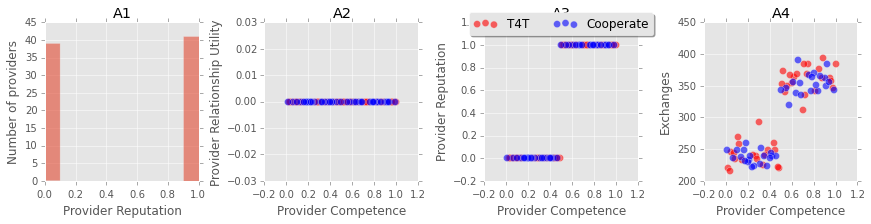

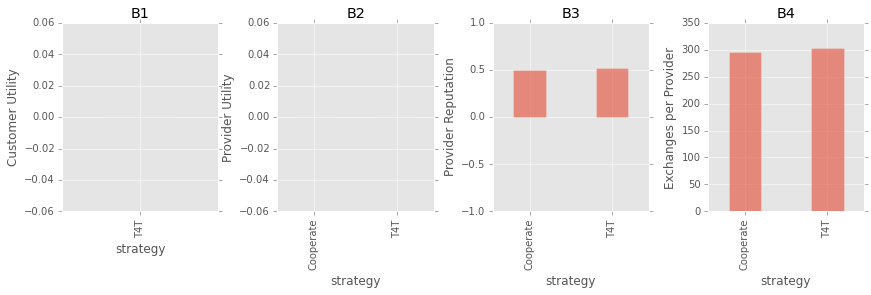

In [10]:
sim = Simulation(
    customer_count = 240,
    provider_count = 80,
    customer_t4t_proportion = 1.0, # all others are Grim or Defect
    provider_t4t_proportion = 0.5, # all others are Cooperate
    rating_periods = 100,
    interactions_per_exchange = 0,
    noise_fraction = 0.1,
    customer_strategies = (STRATEGY_T4T, STRATEGY_DEFECT),
    provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
    )
sim.simulate()
plot_by_competence(sim)
plot_by_strategy(sim)

In this case, strategy is irrelevant because there is no relationship. Chart A3 shows that providers with a sub-par competence under 0.5 get rated badly and have a reputation of zero, while providers with a greater-than-average competence get rated with a thumbs-up by everyone.

This reputation carries over into the number of exchanges that each provider gets (A4): those with a lot reputation get around 250 visits from customers, while those with a good reputation mostly get over 350.

This is how reputation systems are supposed to work, but it is not how reputation systems work for service providers, where most providers get good reputations and where the correlation of competence and reputation is weak.

## Lake Wobegon ratings

Now look at the other extreme, where the provider's competence is unimportant and the social relationship is all that matters. Just as we don't rate friends based on their skills (except perhaps in extreme circumstances), but on their personality and integrity, so competence is not important here.

C:\Users\tom\Miniconda\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


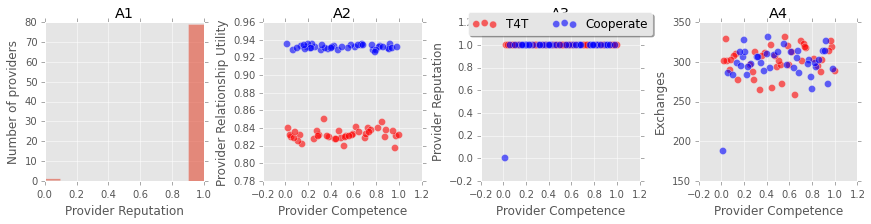

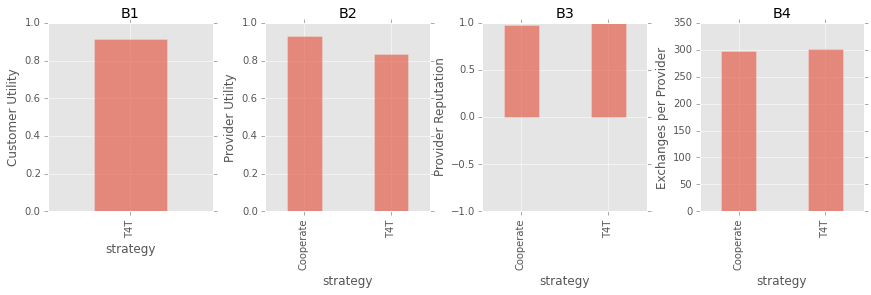

In [152]:
sim = Simulation(
    customer_count = 240,
    provider_count = 80,
    customer_t4t_proportion = 1.0, # all others are Grim or Defect
    provider_t4t_proportion = 0.5, # all others are Cooperate
    rating_periods = 100,
    interactions_per_exchange = 25,
    noise_fraction = 0.1,
    customer_strategies = (STRATEGY_T4T, STRATEGY_DEFECT),
    provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
    )
sim.simulate()
plot_by_competence(sim)
plot_by_strategy(sim)

Here everyone is playing for the social game. Reputation means nothing except for the very worst of providers, because the customers hardly ever provide anything but good ratings, keeping bad ratings to themselves. The reputation system is weak.

But that does not mean that things are bad. B1 shows that customers get a high level of satisfaction (0.9) from the relationship aspect of the exchange - the mutual cooperation of provider and customer. B2 shows that  providers also do well (0.7 or more). So things are good, but different.

## Introducing entitled customers

Now make one change: instead of all customers playing a reciprocal strategy (Tit for Tat), one in ten will be demanding, and will play DEFECT on all aspects of the exchange. Even though the exchange is primarily social, they may rate positively if they get a good outcome (which means, if the provider is compliant) or badly if they do not.

C:\Users\tom\Miniconda\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


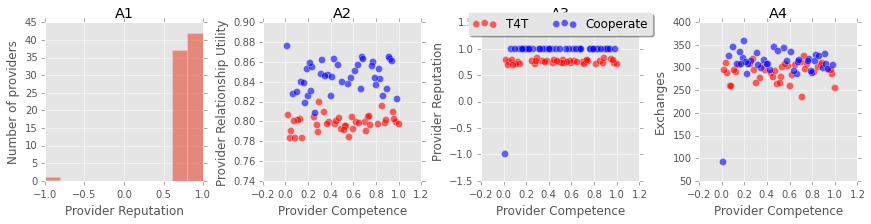

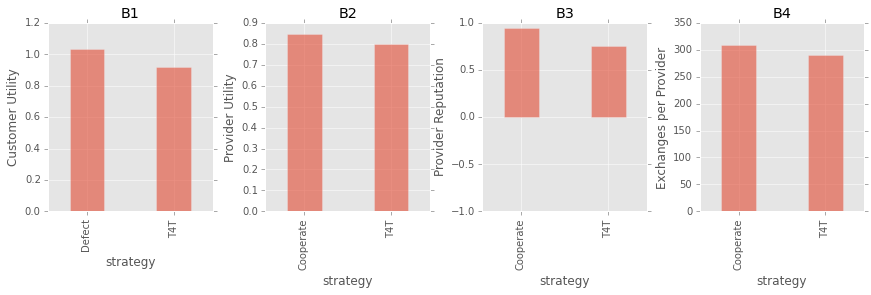

In [153]:
sim = Simulation(
    customer_count = 240,
    provider_count = 80,
    customer_t4t_proportion = 0.9, # all others are Grim or Defect
    provider_t4t_proportion = 0.5, # all others are Cooperate
    rating_periods = 100,
    interactions_per_exchange = 25,
    noise_fraction = 0.1,
    customer_strategies = (STRATEGY_T4T, STRATEGY_DEFECT),
    provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
    )
sim.simulate()
plot_by_competence(sim)
plot_by_strategy(sim)

Figure A1 shows that there are a couple of reputation effects. A very few of the worst providers get low reputations. But there is now a distinction based on strategy too. Those providers who look for a reciprocal relationship (T4T) get thumbs up from similar customers, but they get thumbs down from the entitled customers, because they respond to the initial DEFECT with a DEFECT of their own, and the relationship goes sour. Those who cooperate no matter what get exploited: they have to put up with the continual DEFECT choices of the customer with a smile.

!!NO Figure A2 shows that the T4T providers have a better time of it during the day because they don't put up with the attitudes of entitled customers. But at the end of the day, figures A3 and B3 show that their reputation suffers, and figures A4 and B4 show that their business suffers too: they get about 60 exchanges fewer than the compliant / servile providers.

Meanwhile, the entitled customers are doing fine. Figure B1 shows that by not being selfish, they are doing better than the Tit-for-Tat players by being happy to exploit the compliant providers.

Outside of the very worst providers, competence is not reflected in the provider's reputation: it's the social aspect of the exchange that matters.

So what is happening here is just what we see in most service reputations. From the point of view of the rating system provider itself, this is a better result. The entitled customers are the ones behaving just as they should - not being biased by their relationship with the service provider, delivering an "honest" assessment of the quality of their experience. The collaborative customers, building a relationship with the provider, and reluctant to snitch on them through the rating system, are the ones that are in the wrong from the reputation system point of view.

## More "honest" customers

So let's increase the proportion of entitled customers to see what happens as the rating system "improves".

C:\Users\tom\Miniconda\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


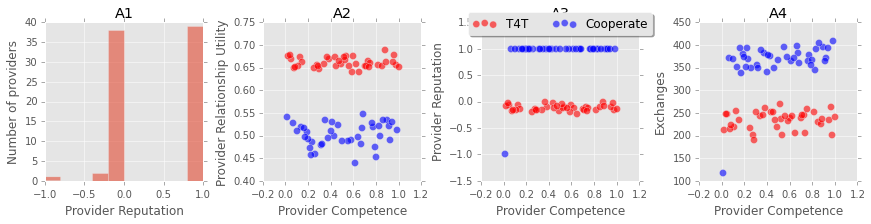

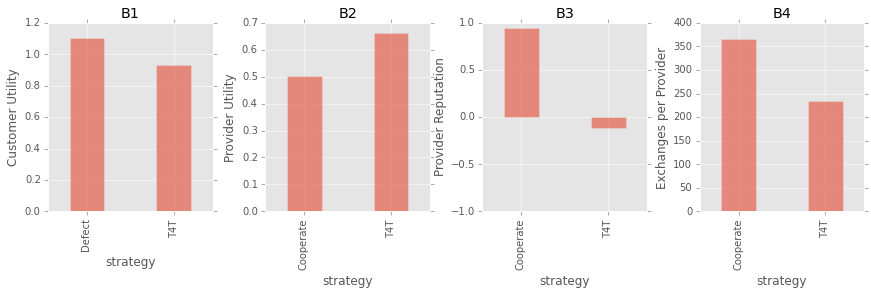

In [155]:
sim = Simulation(
    customer_count = 240,
    provider_count = 80,
    customer_t4t_proportion = 0.5, # all others are Grim or Defect
    provider_t4t_proportion = 0.5, # all others are Cooperate
    rating_periods = 100,
    interactions_per_exchange = 25,
    noise_fraction = 0.1,
    customer_strategies = (STRATEGY_T4T, STRATEGY_DEFECT),
    provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
    )
sim.simulate()
plot_by_competence(sim)
plot_by_strategy(sim)

The split between reciprocal and compliant providers has grown. Compliant providers are having a miserable time during the day (their enjoyment is now lower than that of the customers), but their reputation is better (thanks to the entitled customers) and so they do better (more exchanges). The compliant providers are ruling the roost.

Customers who play DEFECT are also doing better during the day.

C:\Users\tom\Miniconda\envs\py34\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


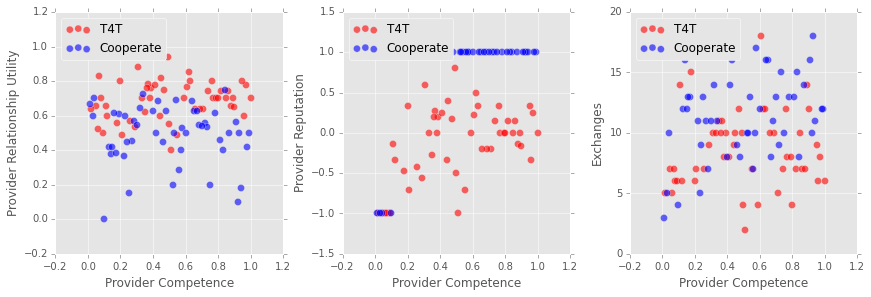

In [177]:
sim = Simulation(
    customer_count = 50,
    provider_count = 100,
    customer_t4t_proportion = 0.5, # all others are Grim or Defect
    provider_t4t_proportion = 0.5, # all others are Cooperate
    rating_periods = 20,
    interactions_per_exchange = 5,
    noise_fraction = 0.0,
    customer_strategies = (STRATEGY_T4T, STRATEGY_DEFECT),
    provider_strategies = (STRATEGY_T4T, STRATEGY_COOPERATE)
    )
sim.simulate()
plot_by_competence(sim)